In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from torch import nn
from torchvision import models
import copy

device = torch.device("cuda")
# %env CUBLAS_WORKSPACE_CONFIG=:4096:8
os.environ["TORCH_HOME"] = "."
import sys

# torch.cuda.is_available()

from torchvision import models

########################################
# parameters to be set in training

dropout = 0.2  # dropout rate in regression layer
lr = 0.001  # learning rate of optimizer
cv_epoches = 100  # cross validate epoches

########################################

############################################
# parameters to be set for encironment
# NOT NEED to modify if you have the setting

data_root_path = "/opt/local/torch/data/tcr-mat-form"  # path to store train data
data_csv_filename = "DataNormilized.csv"  # file to store params to be preprocessed
util_path = "../../.."  # path to store the util package
batch_size = 128  # suitable for 4090
############################################

# add local dir to sys path
sys.path.insert(0, util_path)  # the util package is supposed to be clone to this path

In [2]:
from util.model.surf.modified_cnn_model import (
    ModifiedPretrainedNet,
    SurfNet256,
)
from typing import Any, Dict, Union
from util.model.surf.dateset import SurfDatasetFromMat
from util.model.surf.pretrained_model import PretrainedModelDb
import torch.optim as optim


def define_surf_model(
    model_name: str,
    model_type: Union[int, str],
    suffix: str,
    pretrain: bool = True,
    set_type: str = "train",
    kwd: Dict[str, Any] = {
        "dropout": 0.2,
        "cnn_feature_ratio": 0.5,
        "data_root_path": "/hy-tmp/",
        "data_csv_filename": "DataNormilized.csv",
        "lr": 0.001,
        "num_params": 3,
        "num_output": 2,
    },
):
    """
    定义和配置一个用于表面模型的深度学习模型。

    参数:
    - model_name: 模型的名称。
    - model_type: 模型的类型，可以是整数或字符串。
    - suffix: 附加在模型名称和类型之后的后缀，用于区分不同的模型配置。
    - pretrain: 是否使用预训练的模型权重，默认为True。
    - kwd: 包含模型训练和配置所需的各种参数的字典。

    返回:
    一个包含模型配置和训练所需信息的字典，包括模型前缀、模型实例、数据集、优化器和损失函数。
    """

    # 初始化预训练模型数据库
    model_info_db = PretrainedModelDb()

    # 从数据库中获取指定模型和类型的信息
    train_model, model_weights, name_first_conv, name_fc = model_info_db.get_info(
        model_name, model_type
    )

    # 构造模型前缀，用于后续的日志记录或模型保存
    prefix = f"{model_name}{model_type}_{suffix}"

    # 创建一个修改过的预训练网络实例
    pnet = ModifiedPretrainedNet(
        pretrained_net=train_model,
        weights=model_weights if pretrain else None,
        name_first_conv=name_first_conv,
        name_fc=name_fc,
    )

    # 创建并配置最终的表面模型
    surf_model = SurfNet256(
        modified_net=pnet,
        num_params=kwd["num_params"],
        num_output=kwd["num_output"],
        dropout=kwd["dropout"],
        cnn_feature_ratio=kwd["cnn_feature_ratio"],
    )

    # 将模型移动到指定的设备上
    surf_model.to(device)

    # 创建并配置数据集
    dset = SurfDatasetFromMat(
        data_csv_filename=os.path.join(
            kwd["data_root_path"], set_type, kwd["data_csv_filename"]
        ),
        surf_data_dir=os.path.join(kwd["data_root_path"], set_type, "Surf"),
        param_start_idx=3,
        param_end_idx=6,
        num_targets=2,
    )

    # 创建优化器，用于模型参数的更新
    optimizer = optim.Adam(surf_model.parameters(), lr=kwd["lr"])

    # 定义损失函数，用于衡量模型预测值与真实值的差异
    loss_func = nn.MSELoss()

    # 返回包含模型配置和训练所需信息的字典
    return {
        "prefix": prefix,
        "train_model": surf_model,
        "dset": dset,
        "optimizer": optimizer,
        "loss_func": loss_func,
    }

In [3]:
kwd = {
    "dropout": 0.2,
    "cnn_feature_ratio": 0.5,
    "data_root_path": data_root_path,
    "data_csv_filename": "DataNormilized.csv",
    "lr": 0.001,
    "num_params": 3,
    "num_output": 2,
}
suffix = "input254_cv5_train10000"
model_info = define_surf_model(
    model_name="densenet",
    model_type="121",
    pretrain=False,
    suffix=suffix,
    set_type="test",
    kwd=kwd,
)
model_name = f"{model_info['prefix']}"
root_path = "../../../thesis/surfTopo/checkpoints"

best_checkpoint = torch.load(
    os.path.join(root_path, model_name, f"surf_{model_name}_best.ckpt")
)
# latest_checkpoint = torch.load(
#     os.path.join(root_path, model_name, f"surf_{model_name}_latest.ckpt")
# )

In [4]:
surf_model = model_info["train_model"]
surf_model.load_state_dict(best_checkpoint["model_state_dict"])
optimizer = model_info["optimizer"]
optimizer.load_state_dict(best_checkpoint["optimizer_state_dict"])
test_set = model_info["dset"]
loss_func = model_info["loss_func"]
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [5]:
for name, module in surf_model.named_modules():
    if isinstance(module, nn.ReLU):
        # print(name)
        setattr(module, "inplace", False)

In [6]:
from util.visual.torch.cnn.guided_backprop import GuidedBackprop

In [7]:
gbp = GuidedBackprop(model=surf_model, relu_modules=[surf_model.pretrained_net])

pretrained_net.features.relu0 is hooked!
pretrained_net.features.denseblock1.denselayer1.relu1 is hooked!
pretrained_net.features.denseblock1.denselayer1.relu2 is hooked!
pretrained_net.features.denseblock1.denselayer2.relu1 is hooked!
pretrained_net.features.denseblock1.denselayer2.relu2 is hooked!
pretrained_net.features.denseblock1.denselayer3.relu1 is hooked!
pretrained_net.features.denseblock1.denselayer3.relu2 is hooked!
pretrained_net.features.denseblock1.denselayer4.relu1 is hooked!
pretrained_net.features.denseblock1.denselayer4.relu2 is hooked!
pretrained_net.features.denseblock1.denselayer5.relu1 is hooked!
pretrained_net.features.denseblock1.denselayer5.relu2 is hooked!
pretrained_net.features.denseblock1.denselayer6.relu1 is hooked!
pretrained_net.features.denseblock1.denselayer6.relu2 is hooked!
pretrained_net.features.transition1.relu is hooked!
pretrained_net.features.denseblock2.denselayer1.relu1 is hooked!
pretrained_net.features.denseblock2.denselayer1.relu2 is hooke

In [8]:
for batch in test_loader:
    g = gbp.generate_gradients(batch, loss_func=loss_func)
    break

tensor(8.3125e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


/opt/local/anaconda3/envs/pytorch2/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


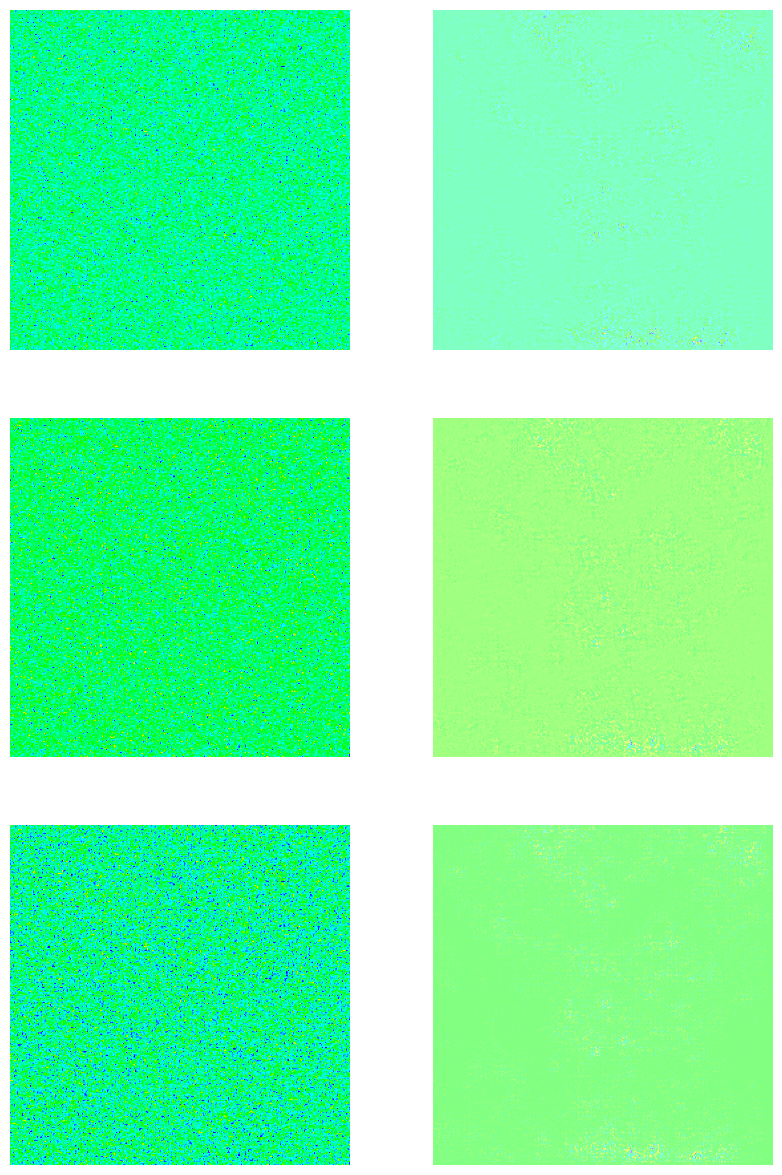

In [26]:
import matplotlib.pyplot as plt

# 创建一个图形

input_surf = batch[0][0]

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

input_kwds = {"cmap": "gist_rainbow"}
grad_kwds = {"alpha": 0.5, "cmap": "gist_rainbow"}

# 显示第一张图片
axes[0, 0].imshow(input_surf[0], zorder=0, **input_kwds)
axes[0, 1].imshow(g[0], zorder=1, **grad_kwds)


# 显示第二张图片
axes[1, 0].imshow(input_surf[1], zorder=0, **input_kwds)
axes[1, 1].imshow(g[1], zorder=1, **grad_kwds)

#
axes[2, 0].imshow(input_surf[0] + input_surf[1], zorder=0, **input_kwds)
axes[2, 1].imshow(g[0] + g[1], zorder=1, **grad_kwds)

for ax in axes.flat:
    ax.axis("off")
# 显示图形
plt.show()